# Volatility Modeling
20 September 2024

by Phat Aphiwatanakoon

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, probplot
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data

In [2]:
df = (
    pd
    .read_csv(
        'SPY ETF Stock Price History.csv', 
        parse_dates=['Date']
    )
    .drop(columns='Change %')
    .rename(
        columns = {
            'Date': 'date', 
            'Price': 'close', 
            'Open': 'open', 
            'High': 'high', 
            'Low': 'low', 
            'Vol.': 'volume'
        }
    )
    .set_index('date')
    .sort_index()
)
df['volume'] = df['volume'].str.slice(stop = -1).astype('float')
ser_price = df['close']

In [3]:
ser_returns = np.log(ser_price / ser_price.shift()).dropna()

# Historical Volatility Models

In [4]:
ser_variance = ser_returns ** 2
df_historical_pred = pd.DataFrame({
    'Historical Average': np.sqrt(ser_variance.cumsum() / np.arange(1, len(ser_variance) + 1)),
    'Simple Moving Average': np.sqrt(ser_variance.rolling(21).sum() / 21),
    'Exponential Moving Average': np.sqrt(ser_variance.ewm(span=len(ser_variance), adjust=False).mean()),
    'Exponential Weighted Moving Average': np.sqrt(ser_variance.ewm(span=21, adjust=False).mean()),
})

In [5]:
test_size = 50
df_historical_pred[-test_size-1:-1].tail()

,Historical Average,Simple Moving Average,Exponential Moving Average,Exponential Weighted Moving Average
date,,,,
2024-08-23,0.010843,0.012649,0.010439,0.010979
2024-08-26,0.010841,0.012425,0.010436,0.010492
2024-08-27,0.010840,0.012428,0.010433,0.010013
2024-08-28,0.010839,0.012443,0.010431,0.009707
2024-08-29,0.010837,0.011935,0.010428,0.009255


In [6]:
def historical_rolling_predictions(series, p=2, q=2, o=0, dist='normal', title=''):
    rolling_predictions = []
    for i in range(test_size):
        train = series[:-(test_size-i)]
        model = arch_model(train, p=p, q=q, o=o, dist=dist)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    plt.figure(figsize=(10,4))
    true, = plt.plot(series.rolling(window=21).std()[-test_size:].values)
    preds, = plt.plot(rolling_predictions)
    plt.title(title)
    plt.legend(['True Volatility', 'Predicted Volatility'])

# ARCH/GARCH

## ACF/PACF Plots

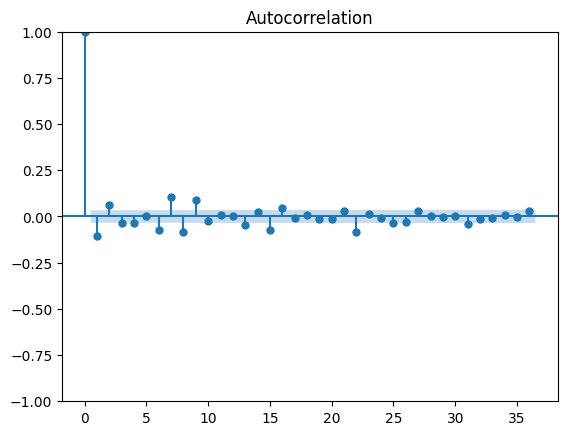

In [7]:
plot_acf(ser_returns)
plt.show()

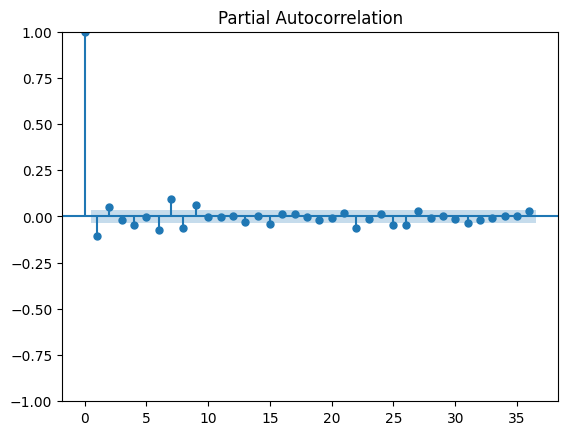

In [8]:
plot_pacf(ser_returns)
plt.show()

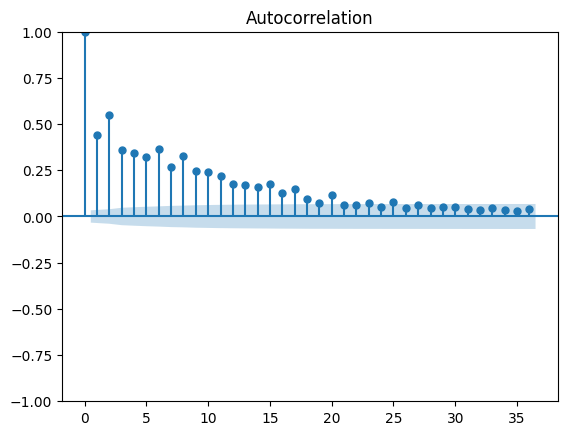

In [9]:
plot_acf((ser_returns - ser_returns.mean()) ** 2)
plt.show()

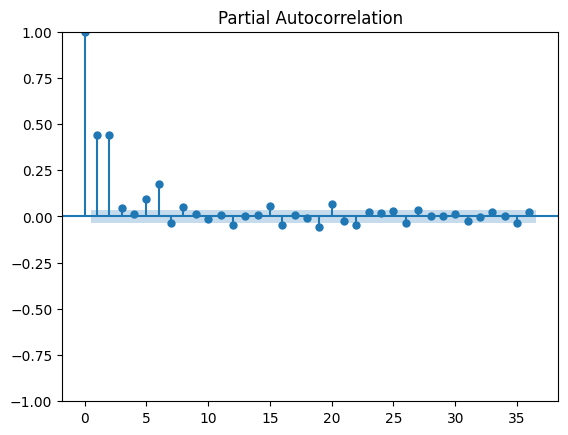

In [10]:
plot_pacf((ser_returns - ser_returns.mean()) ** 2)
plt.show()

## Estimation

In [11]:
model_arch_1 = arch_model(ser_returns * 100, vol='Garch', p=1, q=0)
fitted_model_arch_1 = model_arch_1.fit()
model_garch_1_1 = arch_model(ser_returns * 100, vol='Garch', p=1, q=1)
fitted_model_garch_1_1 = model_garch_1_1.fit()
model_garch_2_2 = arch_model(ser_returns * 100, vol='Garch', p=2, q=2)
fitted_model_garch_2_2 = model_garch_2_2.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 23615.909671883626
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8036.601651099558
Iteration:      3,   Func. Count:     22,   Neg. LLF: 5076.826483704974
Iteration:      4,   Func. Count:     27,   Neg. LLF: 4817.021531015172
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4815.70958913206
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4815.709565603178
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4815.709565603053
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4815.709565603178
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 44203.00668218716
Iteration:      2,   Func. Count:     17,   Neg. LLF: 19923.260267375175
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6759.323797102466
Iteration:      4,   Func. Count:     34,   Neg. LLF: 8754.764056310923


In [12]:
fitted_model_arch_1

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4815.71
Distribution:                  Normal   AIC:                           9637.42
Method:            Maximum Likelihood   BIC:                           9655.85
                                        No. Observations:                 3442
Date:                Thu, Sep 19 2024   Df Residuals:                     3441
Time:                        21:11:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0844  1.707e-02      4.945  7.610e-07 [5.096e-0

In [13]:
fitted_model_garch_1_1

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4368.33
Distribution:                  Normal   AIC:                           8744.65
Method:            Maximum Likelihood   BIC:                           8769.23
                                        No. Observations:                 3442
Date:                Thu, Sep 19 2024   Df Residuals:                     3441
Time:                        21:11:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0775  1.261e-02      6.149  7.806e-10 [5.281e-0

In [14]:
fitted_model_garch_2_2

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4364.44
Distribution:                  Normal   AIC:                           8740.88
Method:            Maximum Likelihood   BIC:                           8777.75
                                        No. Observations:                 3442
Date:                Thu, Sep 19 2024   Df Residuals:                     3441
Time:                        21:11:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0765  1.259e-02      6.079  1.212e-09 [5.185e-0

In [15]:
# Fit a GJR-GARCH model
model_gjr_garch_t = arch_model(
    ser_returns * 100, vol='Garch', p=2, q=2, 
    o=1, dist='t'
)
fitted_model_gjr_garch_t = model_gjr_garch_t.fit(disp='off')

In [16]:
fitted_model_gjr_garch_t

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4223.98
Distribution:      Standardized Student's t   AIC:                           8463.96
Method:                  Maximum Likelihood   BIC:                           8513.11
                                              No. Observations:                 3442
Date:                      Thu, Sep 19 2024   Df Residuals:                     3441
Time:                              21:11:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

## Predict
Source: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Model.ipynb

In [17]:
def display_prediction(model_fit, title = ''):
    predictions = model_fit.forecast(horizon=test_size)
    plt.figure(figsize=(10,4))
    true, = plt.plot((ser_returns * 100).rolling(window=21).std().values[-test_size:])
    preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
    plt.title(title)
    plt.legend(['True Volatility', 'Predicted Volatility'])
    return np.sqrt(predictions.variance.values[-1, :])

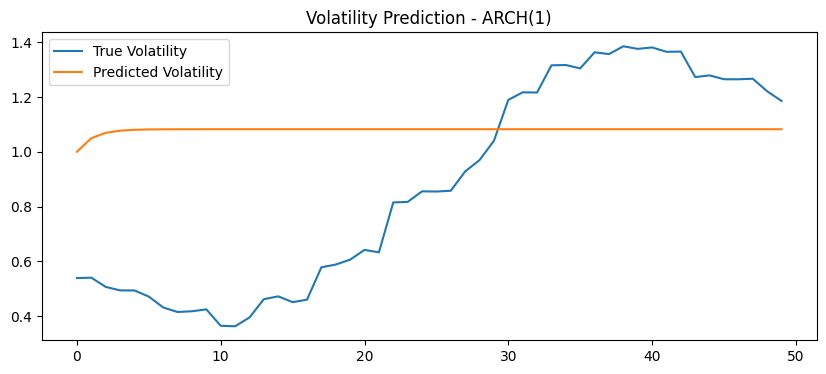

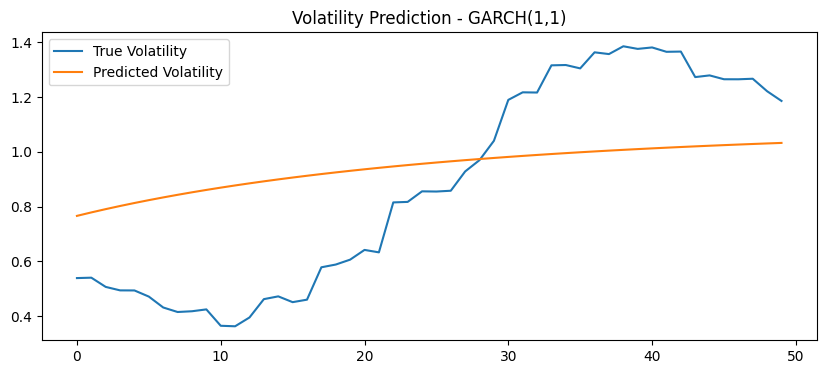

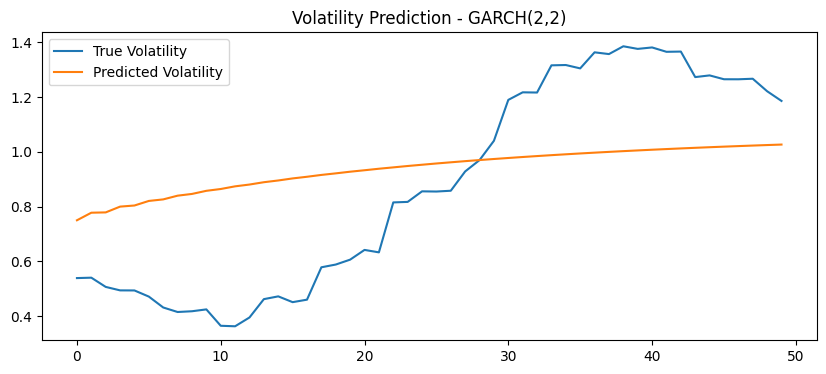

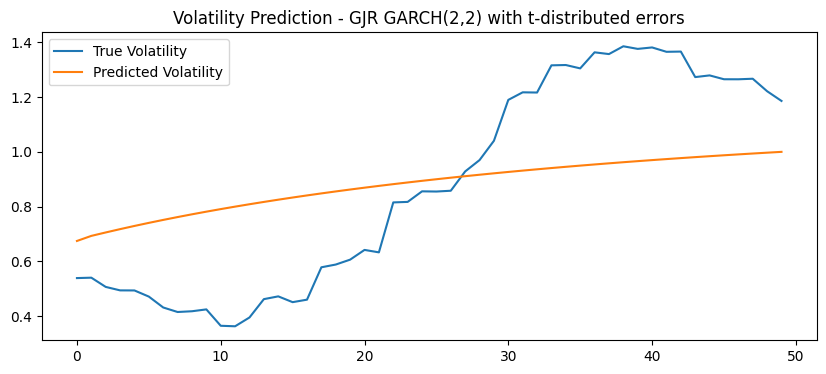

In [18]:
pred_arch_1 = display_prediction(fitted_model_arch_1, title = 'Volatility Prediction - ARCH(1)')
pred_garch_1_1 = display_prediction(fitted_model_garch_1_1, title = 'Volatility Prediction - GARCH(1,1)')
pred_garch_2_2 = display_prediction(fitted_model_garch_2_2, title = 'Volatility Prediction - GARCH(2,2)')
pred_gjr_garch_t = display_prediction(fitted_model_gjr_garch_t, title = 'Volatility Prediction - GJR GARCH(2,2) with t-distributed errors')

## Rolling Forecast Origin
Source: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Model.ipynb

In [19]:
def display_rolling_predictions(series, p=2, q=2, o=0, dist='normal', title=''):
    rolling_predictions = []
    for i in range(test_size):
        train = series[:-(test_size-i)]
        model = arch_model(train, p=p, q=q, o=o, dist=dist)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    plt.figure(figsize=(10,4))
    true, = plt.plot(series.rolling(window=21).std()[-test_size:].values)
    preds, = plt.plot(rolling_predictions)
    plt.title(title)
    plt.legend(['True Volatility', 'Predicted Volatility'])
    return rolling_predictions

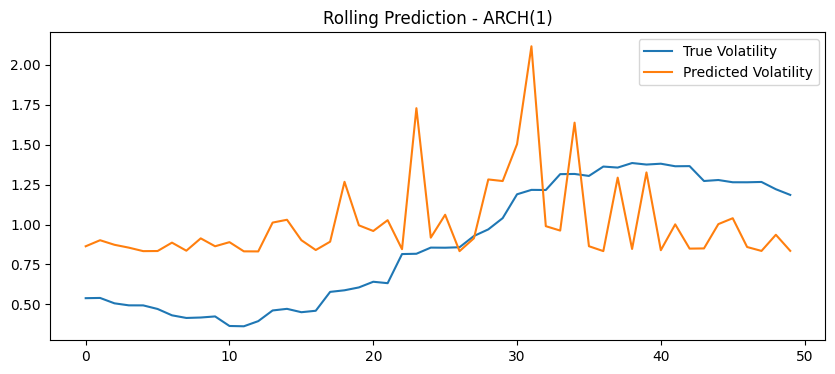

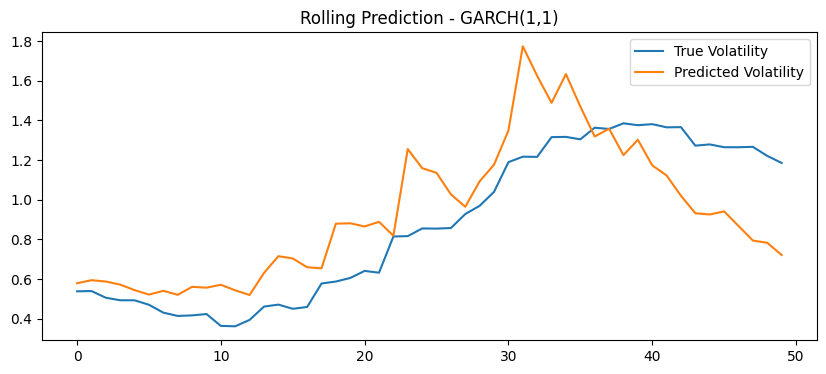

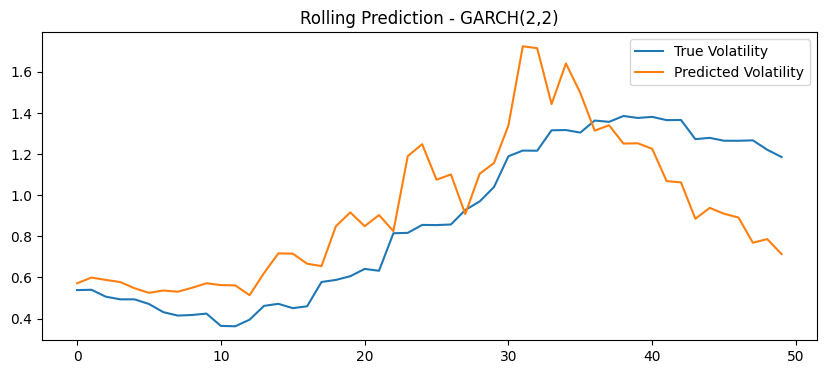

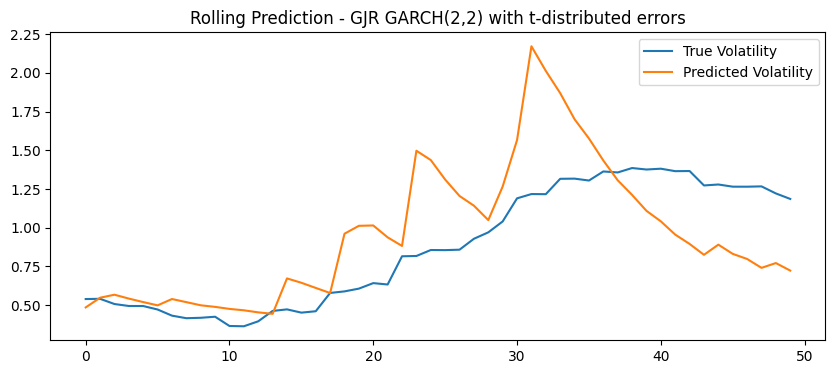

In [20]:
rolling_pred_arch_1 = display_rolling_predictions(series=ser_returns * 100, p = 1, q = 0, title = 'Rolling Prediction - ARCH(1)')
rolling_pred_garch_1_1 = display_rolling_predictions(series=ser_returns * 100, p = 1, q = 1, title = 'Rolling Prediction - GARCH(1,1)')
rolling_pred_garch_2_2 = display_rolling_predictions(series=ser_returns * 100, p = 2, q = 2, title = 'Rolling Prediction - GARCH(2,2)')
rolling_pred_gjr_garch_2_2 = display_rolling_predictions(series=ser_returns * 100, p = 2, q = 2, o = 1, dist = 't', title = 'Rolling Prediction - GJR GARCH(2,2) with t-distributed errors')

## Comparison

In [21]:
def rmse(y_pred, y_true = (ser_returns * 100).rolling(window=21).std().values[-test_size:]):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

pd.Series({
    'HA':               rmse(df_historical_pred[-test_size-1:-1]['Historical Average']),
    'MA':               rmse(df_historical_pred[-test_size-1:-1]['Simple Moving Average']),
    'EMA':              rmse(df_historical_pred[-test_size-1:-1]['Exponential Moving Average']),
    'EWMA':             rmse(df_historical_pred[-test_size-1:-1]['Exponential Weighted Moving Average']),
    'ARCH(1)':          rmse(rolling_pred_arch_1),
    'GARCH(1,1)':       rmse(rolling_pred_garch_1_1),
    'GARCH(2,2)':       rmse(rolling_pred_garch_2_2),
    'GJR GARCH(2,2)':   rmse(rolling_pred_gjr_garch_2_2),
})

HA                0.943535
MA                0.944166
EMA               0.943911
EWMA              0.944333
ARCH(1)           0.417951
GARCH(1,1)        0.249971
GARCH(2,2)        0.253689
GJR GARCH(2,2)    0.352851
dtype: float64

# GBM
## Simulation

In [22]:
# Simulate GBM
def simulate_gbm(s0, mu, sigma, horizon = 1, timesteps = 252, n_sims = 1000):

    # Set the random seed for reproducibility
    np.random.seed(50)

    # Set
    S0 = s0
    T = horizon             # usually = # years
    n = n_sims

    # define dt
    dt = 1 / timesteps      # length of time interval

    # simulate 'n' asset price path with 't' timesteps
    S = np.zeros((T * timesteps, n))
    S[0] = S0

    for i in range(0, T * timesteps - 1):
        W = np.sqrt(dt) * np.random.standard_normal(n)
        S[i+1] = S[i] + mu*S[i]*dt + sigma*S[i]*W
    return S

In [23]:
ser_gbm_price = pd.Series(np.squeeze(simulate_gbm(s0 = 100, mu = .05, sigma = .2, n_sims = 1)))

## Estimation

In [24]:
# Estimate GBM parameters using MLE

# Log returns from the simulated stock prices
ser_gbm_returns = np.diff(np.log(ser_gbm_price))

# Define the negative log-likelihood function for MLE
def nll_gbm(params, returns, dt = 1/252):
    mu, sigma = params
    if sigma <= 0:
        return np.inf  # Penalize non-positive sigma
    # n = len(returns) 
    drift = (mu - 0.5 * sigma**2) * dt
    diff = sigma * np.sqrt(dt)
    # Negative log-likelihood
    ll = norm.logpdf(returns, drift, diff).sum()
    nll = - ll
    # nll = 0.5 * n * np.log(2 * np.pi * diff ** 2) + np.sum((returns - drift)**2) / (2 * diff ** 2)
    return nll  # We minimize the negative log-likelihood

# Initial guess for parameters
initial_guess = [0.05, 0.2]  # Initial guess for mu and sigma

# Perform MLE using the minimize function
result = minimize(nll_gbm, initial_guess, args=(ser_gbm_returns), 
                  bounds=[(-1, 1), (1e-5, 1)])  # Bounds to ensure reasonable results

# Extract estimated parameters
mu_est, sigma_est = result.x

# Print the estimated parameters
mu_est, sigma_est


(np.float64(-0.12938366782938748), np.float64(0.20543400281336172))

In [25]:
mu_est - sigma_est ** 2 / 2, sigma_est

(np.float64(-0.15048523258534763), np.float64(0.20543400281336172))

In [26]:
ser_gbm_returns.mean() * 252, ser_gbm_returns.std()*np.sqrt(252)

(np.float64(-0.1504882190442562), np.float64(0.20543406320813795))

In [27]:
df_gbm = pd.DataFrame(simulate_gbm(s0 = 100, mu = mu_est, sigma = sigma_est))

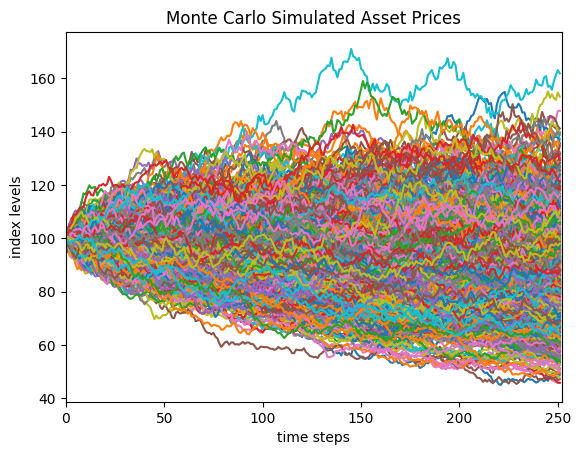

In [28]:
# Plot initial 100 simulated path using matplotlib
plt.plot(df_gbm)
plt.xlabel('time steps')
plt.xlim(0, 252)
plt.ylabel('index levels')
plt.title('Monte Carlo Simulated Asset Prices');

In [29]:
# Use this for TP/SL
percentiles = np.percentile(df_gbm.iloc[-1], [1, 5, 10, 90, 95, 99]) 
percentiles

array([ 52.47153066,  60.80671992,  66.55406171, 112.36273401,
       121.18995043, 134.9613784 ])

# PJD
## Simulation

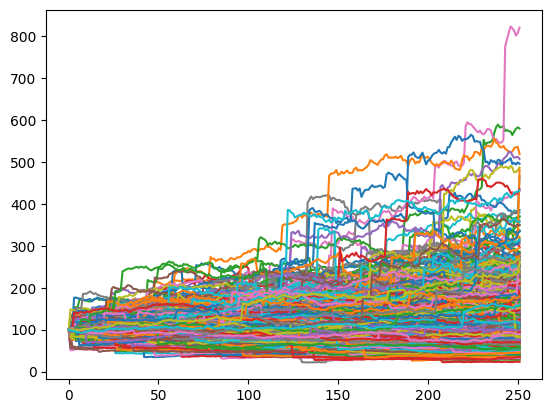

In [30]:
# Simulate PJD
def simulate_pjd(s0, mu, sigma, lam, alpha, delta, horizon = 1, timesteps = 252, n_sims = 1000):

    # Set the random seed for reproducibility
    np.random.seed(50)

    # Set
    S0 = s0
    T = horizon             # usually = # years
    n = n_sims

    # define dt
    dt = 1 / timesteps      # length of time interval

    # simulate 'n' asset price path with 't' timesteps
    S = np.zeros((T * timesteps, n))
    S[0] = S0
    
    for i in range(0, T * timesteps - 1):
        W = np.sqrt(dt) * np.random.standard_normal(n)
        J = np.random.normal(alpha, delta, n)
        N = np.random.poisson(lam * dt, n)
        S[i+1] = S[i] + mu*S[i]*dt + sigma*S[i]*W + J * S[i] * (N > 0)
    return S

S = simulate_pjd(s0=100, mu=0.05, sigma=0.2, lam=5, alpha=.05, delta=.2)
plt.plot(pd.DataFrame(S))
plt.show()

## Estimation

In [31]:
# Log-likelihood function for jump diffusion
def nll_pjd(params, returns, dt = 1/252):
     mu, sigma, lam, alpha, delta = params
    
     # Ensure parameters are positive to maintain valid distributions
     if sigma <= 0 or lam <= 0 or delta <= 0:
          return np.inf  # Return a large number to penalize invalid parameters

     # Precompute constants
     prob_no_jump = np.exp(-lam * dt)
     prob_jump = 1 - prob_no_jump  # For small dt, approx lam * dt
     
     # Density for no jump
     drift_no_jump = (mu - 0.5 * sigma**2) * dt
     diff_no_jump = sigma * np.sqrt(dt)
     pdf_no_jump = norm.pdf(returns, drift_no_jump, diff_no_jump)

     # Density for jump
     drift_jump = drift_no_jump + alpha
     diff_jump = np.sqrt(sigma ** 2 * dt + delta**2) 
     pdf_jump = norm.pdf(returns, drift_jump, diff_jump)
     
     # Total density
     total_pdf = prob_no_jump * pdf_no_jump + lam * dt * prob_jump * pdf_jump
     
     # Avoid log(0) by setting a minimum value
     total_pdf = np.maximum(total_pdf, 1e-300)
     
     # Compute log-likelihood
     log_likelihood = np.sum(np.log(total_pdf))
     
     nll = - log_likelihood
     return nll


In [32]:
ser_pdj_price = pd.Series(np.squeeze(simulate_pjd(s0=100, mu=0.05, sigma=0.2, lam=5, alpha=.05, delta=.2, n_sims=1)))
ser_pdj_returns = np.diff(np.log(ser_pdj_price))


In [33]:
# Initial parameter guesses
params_init = [0.05, 0.2, 5, .05, .2]

# Bounds to ensure parameters remain in a valid range
bounds = [(None, None), (1e-6, None), (1e-6, None), (None, None), (1e-6, None)]

# Optimize the log-likelihood
result = minimize(nll_pjd, params_init, args=(ser_pdj_returns), method='L-BFGS-B', bounds=bounds)
mu_est, sigma_est, lam_est, alpha_est, delta_est = result.x

print("Estimated parameters:")
print(f"mu = {mu_est}")
print(f"sigma = {sigma_est}")
print(f"lambda = {lam_est}")
print(f"alpha = {alpha_est}")
print(f"delta = {delta_est}")

Estimated parameters:
mu = -0.45215183968607353
sigma = 0.2028481813245381
lambda = 14.635637551960489
alpha = 0.04936470850350823
delta = 0.16609659931096019


In [34]:
df_pjd = pd.DataFrame(simulate_pjd(s0=100, mu=0.05, sigma=0.2, lam=5, alpha=.05, delta=.2))

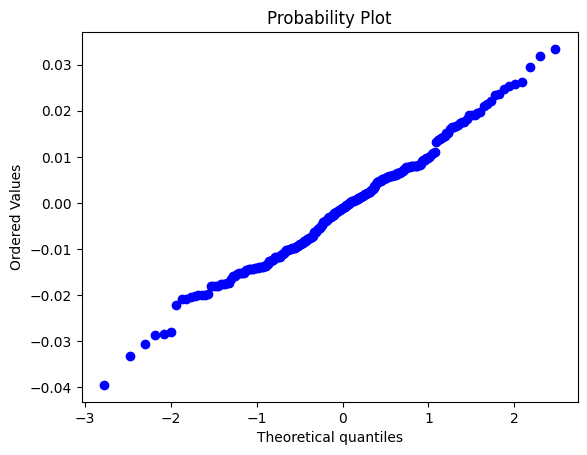

In [35]:
probplot(np.log(df_gbm / df_gbm.shift()).iloc[:, 0], dist="norm", plot=plt)
plt.show()

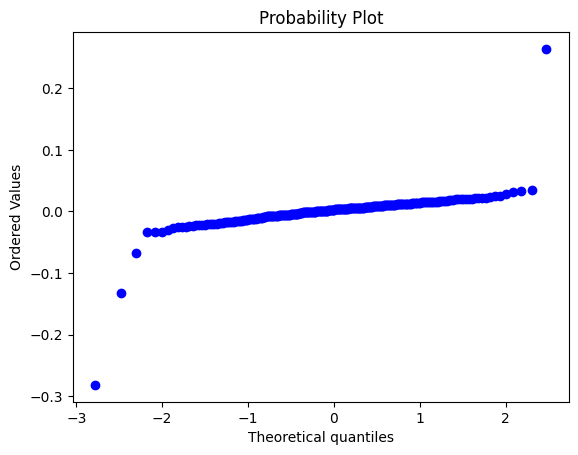

In [36]:
df_pjd = pd.DataFrame(S)
probplot(np.log(df_pjd / df_pjd.shift()).iloc[:, 0], dist="norm", plot=plt)
plt.show()


In [37]:
# Use this for TP/SL
percentiles = np.percentile(df_pjd.iloc[-1], [1, 5, 10, 90, 95, 99]) 
percentiles

array([ 35.60509287,  52.25280488,  63.98129322, 220.01820911,
       253.74799726, 430.25923803])

In [38]:
# Compare with GBM
np.percentile(df_gbm.iloc[-1], [1, 5, 10, 90, 95, 99]) 

array([ 52.47153066,  60.80671992,  66.55406171, 112.36273401,
       121.18995043, 134.9613784 ])

# Using data

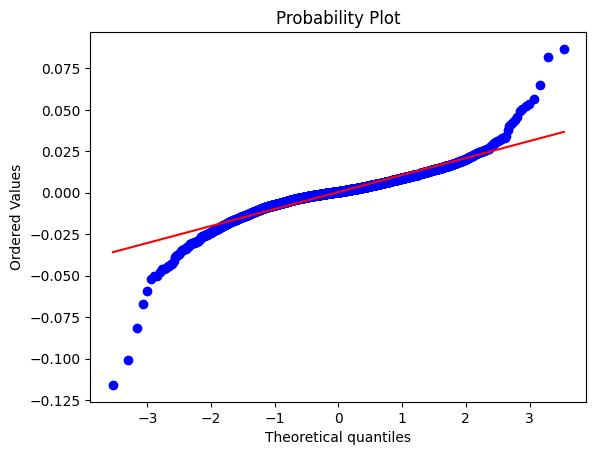

In [39]:
probplot(ser_returns, dist="norm", plot=plt)
plt.show()


In [40]:
initial_guess = [0.05, 0.2]  # Initial guess for mu and sigma

# Bounds to ensure parameters remain in a valid range
bounds = [(-1, 1), (1e-5, 1)]

# Perform MLE using the minimize function
result = minimize(
    nll_gbm, 
    initial_guess, 
    args=(ser_returns.dropna()), 
    bounds=bounds     # Bounds to ensure reasonable results
)

# Extract estimated parameters
mu_est_gbm, sigma_est_gbm = result.x

print("Estimated parameters:")
print(f"mu = {mu_est_gbm}")
print(f"sigma = {sigma_est_gbm}")

Estimated parameters:
mu = 0.12385240164472511
sigma = 0.1718913420984464


In [41]:
params_init = [0.05, 0.2, 5, .05, .2]   # Initial parameter guesses

# Bounds to ensure parameters remain in a valid range
bounds = [(None, None), (1e-6, None), (1e-6, None), (None, None), (1e-6, None)]

# Optimize the log-likelihood
result = minimize(
    nll_pjd, 
    params_init, 
    args=(ser_returns.dropna()), 
    method='L-BFGS-B', 
    bounds=bounds
)

# Extract estimated parameters
mu_est_pjd, sigma_est_pjd, lam_est_pjd, alpha_est_pjd, delta_est_pjd = result.x

print("Estimated parameters:")
print(f"mu = {mu_est_pjd}")
print(f"sigma = {sigma_est_pjd}")
print(f"lambda = {lam_est_pjd}")
print(f"alpha = {alpha_est_pjd}")
print(f"delta = {delta_est_pjd}")

Estimated parameters:
mu = 0.1437043217062225
sigma = 0.15117423353681886
lambda = 3.5413052943392973
alpha = -0.013148080684250742
delta = 0.060179584918791405


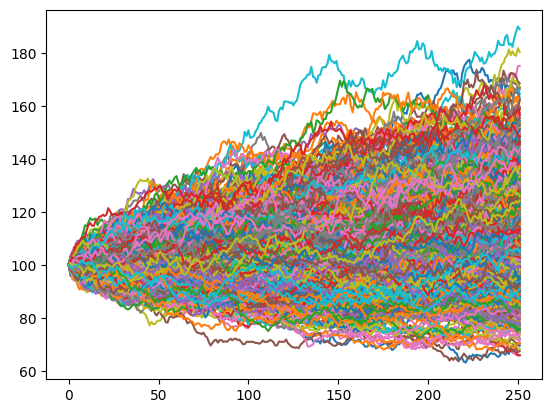

In [42]:
simulate_gbm_results = simulate_gbm(
    s0=100, 
    mu=mu_est_gbm, 
    sigma=sigma_est_gbm
)

plt.plot(pd.DataFrame(simulate_gbm_results))
plt.show()

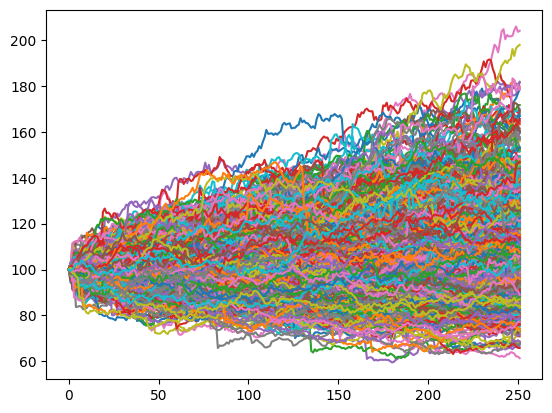

In [43]:
simulate_pjd_results = simulate_pjd(
    s0=100, 
    mu=mu_est_pjd, 
    sigma=sigma_est_pjd, 
    lam=lam_est_pjd, 
    alpha=alpha_est_pjd, 
    delta=delta_est_pjd
)

plt.plot(pd.DataFrame(simulate_pjd_results))
plt.show()

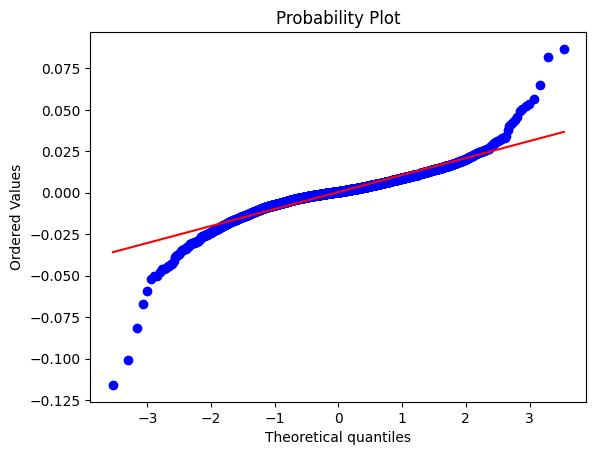

In [44]:
probplot(ser_returns.dropna(), dist="norm", plot=plt, )
plt.show()


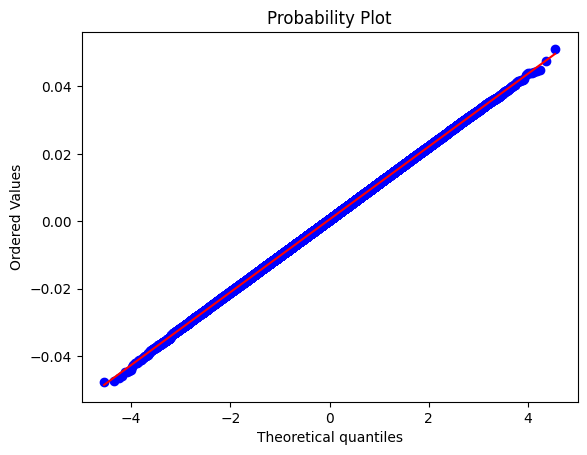

In [45]:
probplot(pd.DataFrame(simulate_gbm_results).pct_change().dropna().values.flatten(), dist="norm", plot=plt)
plt.show()

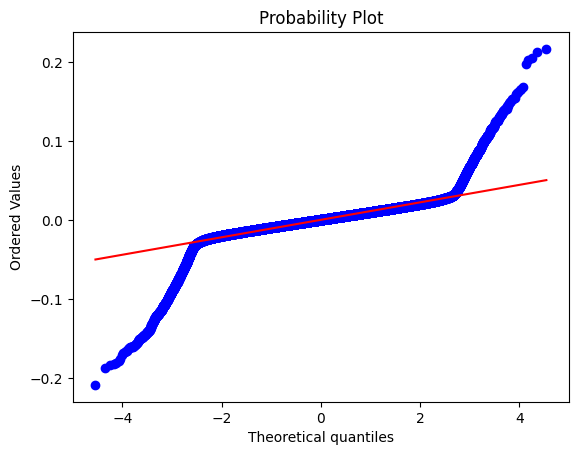

In [46]:
probplot(pd.DataFrame(simulate_pjd_results).pct_change().dropna().values.flatten(), dist="norm", plot=plt)
plt.show()